In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

import gmsh
from firedrake import *
from firedrake.pyplot import triplot

## ITER mesh generation

In this notebook, starting from an image of a ITER mesh, an equal mesh compatible with Firedrake is generated using gmsh.
The splines that provide the shape of the vacuum vessel walls and the limiter are extracted using imaging tecniques.
The coordinates of the coils rectangles are extracted by ..
The mesh is then generated using the gmsh python library.

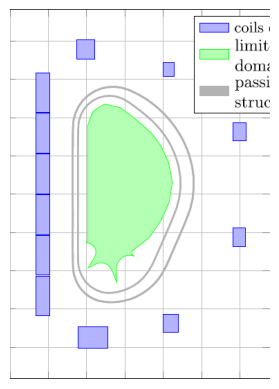

In [2]:
# Load the image
img = cv2.imread("ITER_figure.png")
plt.imshow(img)
plt.axis('off')
plt.show()

# Extract splines from black/white image

To allow spline extraction with cv2, first the background grid needs to be eliminated from the image since it pollutes the binary black/white image used to extract the spline

Text(0.5, 1.0, 'Combined Mask')

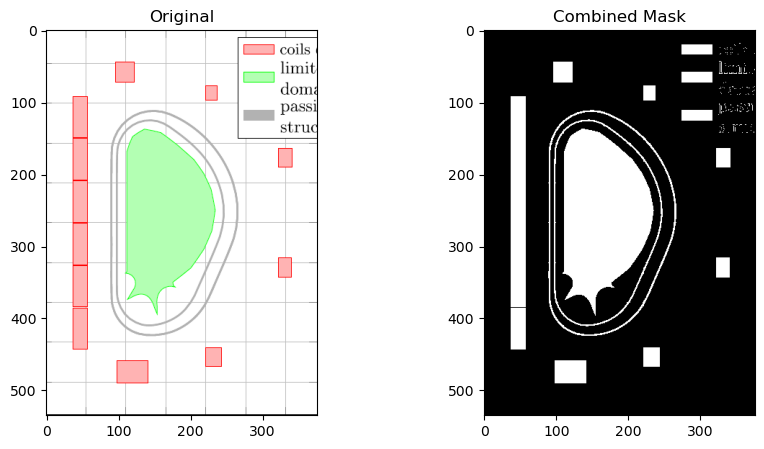

In [3]:
# Convert to HSV for red and green detection
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# --- RED COILS MASK ---
lower_red1 = np.array([0, 70, 50])
upper_red1 = np.array([10, 255, 255])
mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)

lower_red2 = np.array([170, 70, 50])
upper_red2 = np.array([180, 255, 255])
mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)

mask_red = cv2.bitwise_or(mask_red1, mask_red2)

# --- GREEN LIMITER MASK ---
lower_green = np.array([40, 40, 40])
upper_green = np.array([90, 255, 255])
mask_green = cv2.inRange(hsv, lower_green, upper_green)

# --- DARK & GREY VESSEL MASK (using grayscale) ---
# The vessel walls are light gray, but not as light as the white background grid.
# We'll threshold for a range that captures gray but excludes the white grid.

# Assume: grid is pure white (255), vessel walls are light gray (e.g., 180-230)
# You may need to adjust these values based on your image.

# Create mask for gray vessel walls
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lower_gray = 160  # lower bound for vessel wall gray
upper_gray = 190  # upper bound for vessel wall gray
mask_gray = cv2.inRange(gray, lower_gray, upper_gray)

# --- Combine masks ---
combined_mask = cv2.bitwise_or(mask_red, mask_green)
combined_mask = cv2.bitwise_or(combined_mask, mask_gray)

# Optional: clean small blobs
kernel = np.ones((2, 2), np.uint8)
cleaned_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel, iterations=1)

# Show results
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(combined_mask, cmap='gray')
plt.title("Combined Mask")


In [4]:
# Filter out multiple contours that refer to the same feature (very close together)
def filter_close_contours(contours, min_distance=10):
    filtered = []
    for contour in contours:
        if len(filtered) == 0:
            filtered.append(contour)
            continue
        #last_contour = filtered[-1]
        last_contour = filtered[-1]
        # Calculate distance between last contour and current contour
        pt = tuple(map(float, contour[0][0]))
        dist = cv2.pointPolygonTest(last_contour, pt, True)
        if abs(dist) > min_distance:
            filtered.append(contour)
    return filtered

# Helper to fit a spline to a contour
def fit_spline_to_contour(contour, s=10.0):
    contour = contour.squeeze()
    if contour.ndim != 2 or contour.shape[0] < 8:
        return None, None
    x, y = contour[:, 0], contour[:, 1]
    tck, u = splprep([x, y], s=s, per=True)
    u_fine = np.linspace(0, 1, 400)
    x_fine, y_fine = splev(u_fine, tck)
    return (x_fine, y_fine), tck

Contour 0: area=44509.0, hierarchy=[ 1 -1 -1 -1]
Contour 1: area=33994.0, hierarchy=[ 2  0 -1 -1]
Contour 2: area=22016.0, hierarchy=[ 3  1 -1 -1]
Contour 3: area=5840.0, hierarchy=[ 4  2 -1 -1]
Contour 4: area=1333.0, hierarchy=[ 5  3 -1 -1]
Contour 5: area=1140.0, hierarchy=[ 6  4 -1 -1]
Contour 6: area=728.0, hierarchy=[11  5  7 -1]
Contour 7: area=588.0, hierarchy=[-1 -1  8  6]
Contour 8: area=588.0, hierarchy=[-1 -1  9  7]
Contour 9: area=572.0, hierarchy=[-1 -1 10  8]
Contour 10: area=546.0, hierarchy=[-1 -1 -1  9]
Contour 11: area=494.0, hierarchy=[12  6 -1 -1]
Contour 12: area=486.0, hierarchy=[13 11 -1 -1]
Contour 13: area=320.0, hierarchy=[14 12 -1 -1]


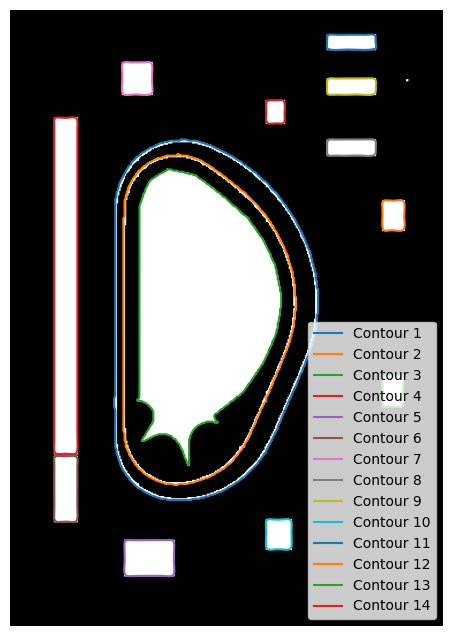

In [5]:
# Assume 'cleaned_mask' is your binary mask (white = features, black = background)
# Find contours
contours, hierarchy = cv2.findContours(cleaned_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# Remove small contours that are likely noise
contours = [c for c in contours if cv2.contourArea(c) > 100]

# Filter out multiple contours that refer to the same feature (very close together)
contours = filter_close_contours(contours)

# Sort contours by area (largest is the outermost)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

for idx, (contour, h) in enumerate(zip(contours, hierarchy[0])):
    print(f"Contour {idx}: area={cv2.contourArea(contour)}, hierarchy={h}")

# Fit splines and plot all contours
plt.figure(figsize=(8, 8))
plt.imshow(cleaned_mask, cmap='gray')

for idx, contour in enumerate(contours):
    spline, tck = fit_spline_to_contour(contour)
    if spline:
        plt.plot(spline[0], spline[1], label=f'Contour {idx+1}')

plt.legend()
plt.axis('off')
plt.show()


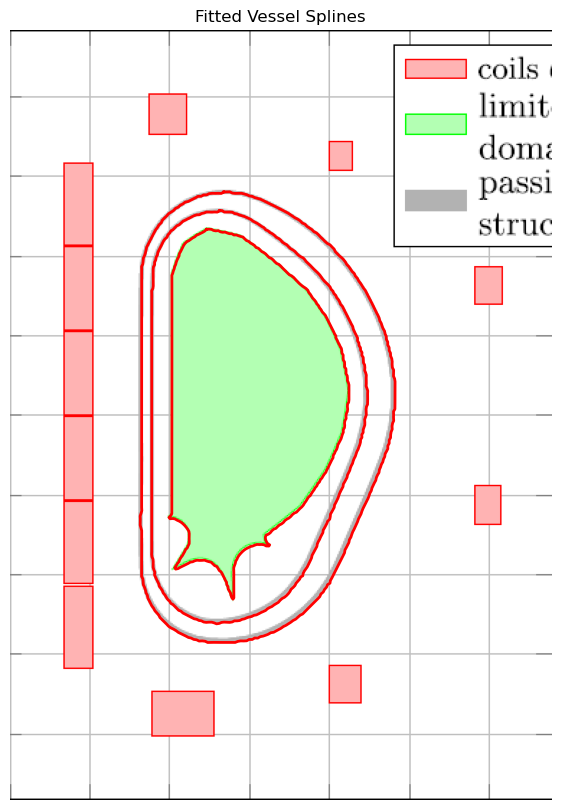

In [6]:
# Consider just the contours related to vessel walls and limiter:
vessel_contours = contours[:3]

# Fit splines to the vessel contours
vessel_splines = []
for contour in vessel_contours:
    spline, tck = fit_spline_to_contour(contour)
    if spline:
        vessel_splines.append(spline)

# Plot the original image with the fitted splines
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
for idx, spline in enumerate(vessel_splines):
    plt.plot(spline[0], spline[1], label=f'Vessel Spline {idx+1}', linewidth=2, color='red')
plt.title("Fitted Vessel Splines")
plt.axis('off')
plt.show()

# Splines post-processing

Here the splines extracted are "cleaned" by removing undesired points on the left-side line and removing points which are too close to improve performance in the mesh generation.

In [7]:
def normalize_spline(x, y, bbox_src, bbox_dst):
    x_norm = (x - bbox_src[0]) / (bbox_src[1] - bbox_src[0])
    y_norm = (y - bbox_src[2]) / (bbox_src[3] - bbox_src[2])
    x_dst = bbox_dst[0] + x_norm * (bbox_dst[1] - bbox_dst[0])
    y_dst = - (bbox_dst[2] + y_norm * (bbox_dst[3] - bbox_dst[2]))
    return x_dst, y_dst

def remove_close_points(x, y, min_dist):
    """Remove points that are closer than min_dist."""
    new_x = [x[0]]
    new_y = [y[0]]
    for xi, yi in zip(x[1:], y[1:]):
        dist = np.hypot(xi - new_x[-1], yi - new_y[-1])
        if dist >= min_dist:
            new_x.append(xi)
            new_y.append(yi)

    # Ensure first and last points are NOT the same
    if len(new_x) > 1 and ((abs(new_x[0] - new_x[-1]) < 0.01) and (abs(new_y[0] - new_y[-1]) < 0.01)):
        new_x.pop()
        new_y.pop()
        
    return np.array(new_x), np.array(new_y)

# Fix incorrect deviations by translating the leftmost points in splines
# that are not aligned with the expected leftmost point
def fix_leftmost_point(x, y):
    """Remove the point with the smallest x value from the spline."""
    if len(x) == 0:
        return x, y
    #identify the leftmost point:
    min_idx = np.argmin(x)
    # Identify the successive point:    
    # Replace the x coordinate of the leftmost point with the previous point's x
    x_new = np.copy(x)
    y_new = np.copy(y)
    if len(x) > 1:
        previous_idx = (min_idx - 1) % len(x)
        x_new[min_idx] = x[previous_idx]

    return x_new, y_new

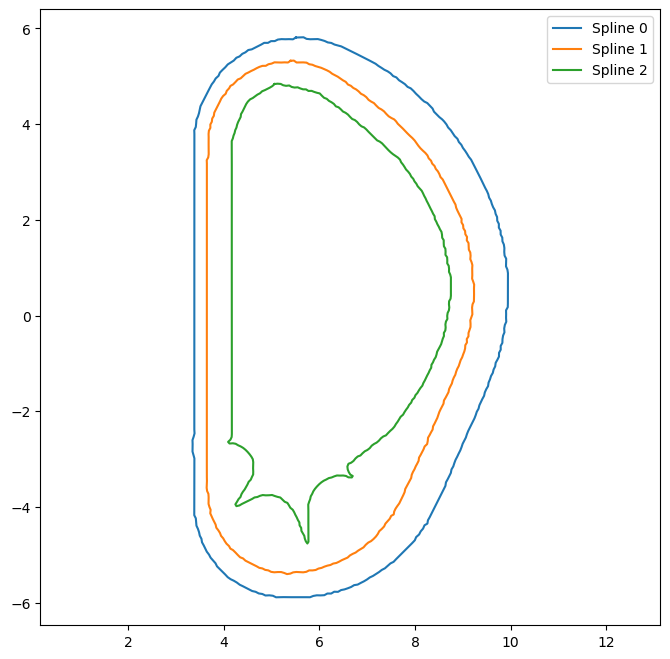

In [8]:
# --- Define bounding boxes ---
# Source bounding box (image coordinates)
bbox_src = (0, cleaned_mask.shape[1], 0, cleaned_mask.shape[0])  # (xmin, xmax, ymin, ymax)
# Destination bounding box (Gmsh rectangle)
bbox_dst = (0, 14, -10, 10)  # (xmin, xmax, ymin, ymax)

# --- Normalize all splines ---
splines = []
for x, y in vessel_splines:
    x_new, y_new = normalize_spline(np.array(x), np.array(y), bbox_src, bbox_dst)
    splines.append((x_new, y_new))

# Plot splines to verify
plt.figure(figsize=(8,8))
for i, (x, y) in enumerate(splines):
    plt.plot(x, y, label=f"Spline {i}")
plt.legend()
plt.axis('equal')
plt.show()


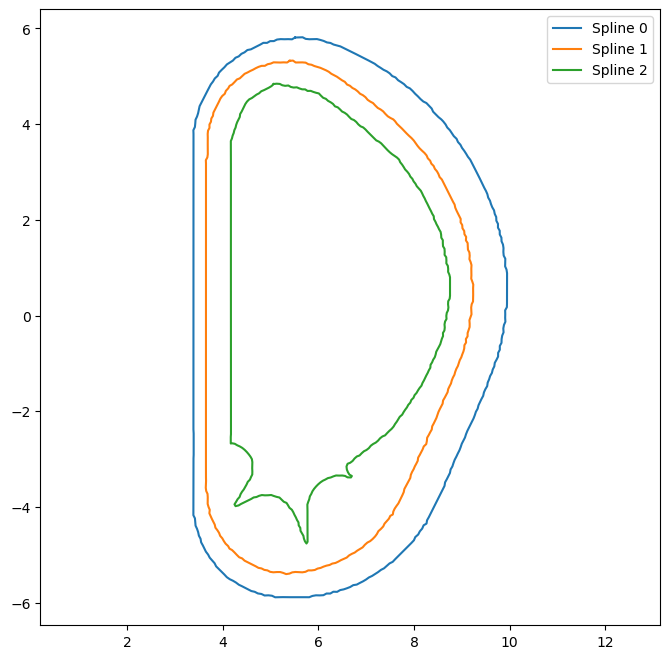

In [9]:
# --- Fix leftmost points ---

# After manual trials -> 12 times required to fix the v
for i in range(14):
    x, y = splines[0]
    splines[0] = fix_leftmost_point(x, y)

# After manual trials -> 5 times required to fix the limiter spline
for i in range(5):
    x, y = splines[2]
    splines[2] = fix_leftmost_point(x, y)

# Plot splines to verify
plt.figure(figsize=(8,8))
for i, (x, y) in enumerate(splines):
    plt.plot(x, y, label=f"Spline {i}")
plt.legend()
plt.axis('equal')
plt.show()

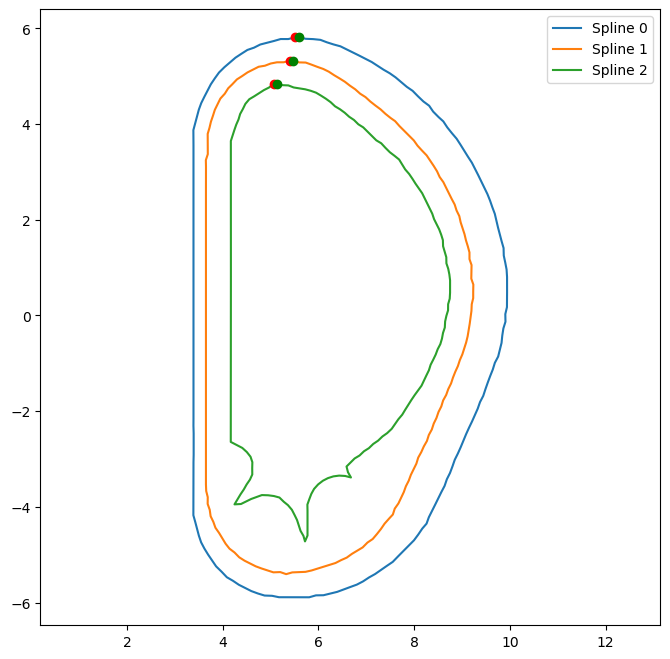

In [10]:
# --- Remove close points ---
simplified_splines = []
for x, y in splines:
    x_s, y_s = remove_close_points(x, y, min_dist=0.1)  # adjust min_dist as needed
    simplified_splines.append((x_s, y_s))

# Plot splines to verify
plt.figure(figsize=(8,8))
for i, (x, y) in enumerate(simplified_splines):
    plt.plot(x, y, label=f"Spline {i}")

# Highlight the first and last points of each spline to check for orientation:
for i, (x, y) in enumerate(simplified_splines):
    plt.plot(x[0], y[0], 'ro')  # First point
    plt.plot(x[-1], y[-1], 'go')  # Last point

plt.legend()
plt.axis('equal')
plt.show()

Notice that all the splines have the points ordered in counterclockwise sense. This is essential for meshing since gmsh requires the external curve loop of a region to be counterclockwise and the internal one to be clockwise.

# Extract the coils coordinates

By opening the image on paint, I extract the coils coordinates in pixels. The coils are in order from 1 to 12 and the coordinates start always with the low-lewft point and advance in counterclockwise sense.

In [11]:
coil_1_pixels = [(37,149), (57,149), (57,92), (37,92)]

coils_7_12_pixels = [ [(96,72), (122,72), (122,44), (96,44)]
                , [(221,97), (237,97), (237,77), (221,77)]
                , [(322,190), (340,190), (340,164), (322,164)]
                , [(322,343), (340,343), (340,317), (322,317)]
                , [(221,467), (243,467), (243,441), (221,441)]
                , [(98,490), (141,490), (141,459), (98,459)]
]

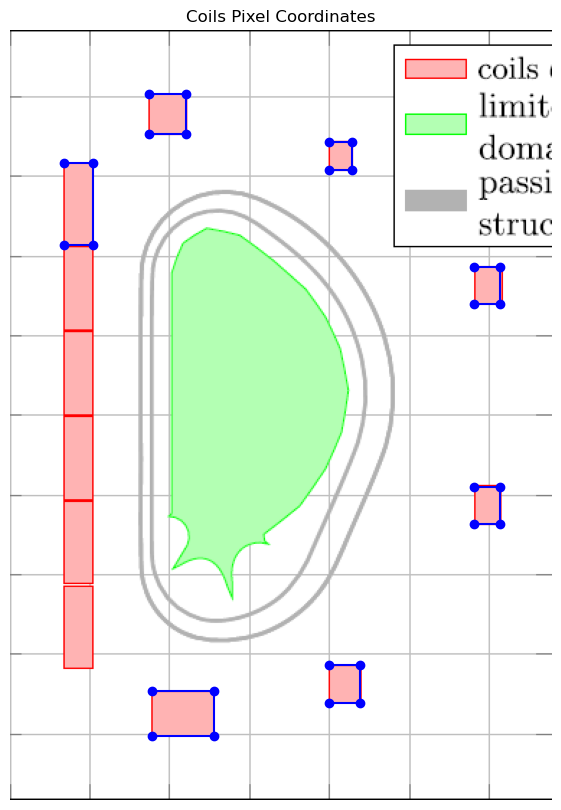

In [12]:
# Plot over the image to verify if the pixel coordinates are correct:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
coil1 = np.array(coil_1_pixels)
plt.plot(coil1[:,0], coil1[:,1], 'bo-')
for coil in coils_7_12_pixels:
    coil = np.array(coil)
    plt.plot(coil[:, 0], coil[:, 1], 'bo-')
plt.title("Coils Pixel Coordinates")
plt.axis('off')
plt.show()

In [13]:
# Convert pixel coordinates to normalized coordinates
def convert_pixels_to_normalized(coords, bbox_src, bbox_dst):
    x_norm = (coords[0] - bbox_src[0]) / (bbox_src[1] - bbox_src[0])
    y_norm = (coords[1] - bbox_src[2]) / (bbox_src[3] - bbox_src[2])
    x_dst = bbox_dst[0] + x_norm * (bbox_dst[1] - bbox_dst[0])
    y_dst = - (bbox_dst[2] + y_norm * (bbox_dst[3] - bbox_dst[2]))
    return x_dst, y_dst

In [14]:
# Convert isolated coils (from 7 to 12) in normalized coordinates
coils_7_12 = []
for coil in coils_7_12_pixels:
    coil_normalized = [convert_pixels_to_normalized(pt, bbox_src, bbox_dst) for pt in coil]
    coils_7_12.append(coil_normalized)

# Convert coil 1 in normalized coordinates:
coil_1_normalized = [convert_pixels_to_normalized(pt, bbox_src, bbox_dst) for pt in coil_1_pixels]

x0 = coil_1_normalized[0][0]        # left endpoint of the block of coils on the left
x1 = coil_1_normalized[1][0]        # right endpoint of the block of coils on the left
h = coil_1_normalized[3][1] - coil_1_normalized[0][1]                              # height of each coil in the block

# Create the set of points for the block of coils on the left:
coils_1_6 = [ (x0, 3*h) , (x1, 3*h) , (x0, 2*h) , (x1, 2*h)
            , (x0, h) , (x1, h) , (x0, 0), (x1, 0)
            , (x0, -h), (x1, -h), (x0, -2*h), (x1, -2*h)
            , (x0, -3*h), (x1, -3*h)
]

# Generate mesh using gmsh

In [23]:
gmsh.initialize()
gmsh.model.add("ITER")


#--------------------------------------------------#
#               RECTANGULAR BOUNDARY               #
#--------------------------------------------------#
p1 = gmsh.model.geo.addPoint(0, -10, 0)
p2 = gmsh.model.geo.addPoint(14, -10, 0)
p3 = gmsh.model.geo.addPoint(14, 10, 0)
p4 = gmsh.model.geo.addPoint(0, 10, 0)

l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

rectangle_loop = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])  # counter-clockwise orientation


#--------------------------------------------------#
#               VESSEL AND LIMITER                 #
#--------------------------------------------------#
loops = []           # Curve loop tags
lines_tags = []      # Lines (for physical groups)

for x, y in simplified_splines:
    points = [gmsh.model.geo.addPoint(float(xi), float(yi), 0) for xi, yi in zip(x, y)]
    lines = []
    for i in range(len(points) - 1):
        lines.append(gmsh.model.geo.addLine(points[i], points[i+1]))
    lines.append(gmsh.model.geo.addLine(points[-1], points[0]))  # Close loop

    loop = gmsh.model.geo.addCurveLoop(lines)
    loops.append(loop)
    lines_tags.append(lines)

#--------------------------------------------------#
#                    COILS 1-6                     #
#--------------------------------------------------#

coil_block_pts = [gmsh.model.geo.addPoint(float(x), float(y), 0) for x, y in coils_1_6]

# Horizontal left-to-right lines (from top to bottom)
h1 = gmsh.model.geo.addLine(coil_block_pts[0], coil_block_pts[1])
h2 = gmsh.model.geo.addLine(coil_block_pts[2], coil_block_pts[3])
h3 = gmsh.model.geo.addLine(coil_block_pts[4], coil_block_pts[5])
h4 = gmsh.model.geo.addLine(coil_block_pts[6], coil_block_pts[7])
h5 = gmsh.model.geo.addLine(coil_block_pts[8], coil_block_pts[9])
h6 = gmsh.model.geo.addLine(coil_block_pts[10], coil_block_pts[11])
h7 = gmsh.model.geo.addLine(coil_block_pts[12], coil_block_pts[13])

# Vertical lines on the left (from top to bottom):
vl1 = gmsh.model.geo.addLine(coil_block_pts[0], coil_block_pts[2])
vl2 = gmsh.model.geo.addLine(coil_block_pts[2], coil_block_pts[4])
vl3 = gmsh.model.geo.addLine(coil_block_pts[4], coil_block_pts[6])
vl4 = gmsh.model.geo.addLine(coil_block_pts[6], coil_block_pts[8])
vl5 = gmsh.model.geo.addLine(coil_block_pts[8], coil_block_pts[10])
vl6 = gmsh.model.geo.addLine(coil_block_pts[10], coil_block_pts[12])

# Vertical lines on the right (from top to bottom):
vr1 = gmsh.model.geo.addLine(coil_block_pts[1], coil_block_pts[3])
vr2 = gmsh.model.geo.addLine(coil_block_pts[3], coil_block_pts[5])
vr3 = gmsh.model.geo.addLine(coil_block_pts[5], coil_block_pts[7])
vr4 = gmsh.model.geo.addLine(coil_block_pts[7], coil_block_pts[9])
vr5 = gmsh.model.geo.addLine(coil_block_pts[9], coil_block_pts[11])
vr6 = gmsh.model.geo.addLine(coil_block_pts[11], coil_block_pts[13])

# Line loop for the block of coils (clockwise orientation for hole)
coils_block_boundary_lines = [h1, vr1, vr2, vr3, vr4, vr5, vr6, -h7, -vl6, -vl5, -vl4, -vl3, -vl2, -vl1]
coils_block_hole = gmsh.model.geo.addCurveLoop(coils_block_boundary_lines)

# Coils loops (counterclockwise orientation for regions)
coils_1_6_lines = [
    [h2,-vr1,-h1,vl1], # Coil 1
    [h3,-vr2,-h2,vl2], # Coil 2
    [h4,-vr3,-h3,vl3], # Coil 3
    [h5,-vr4,-h4,vl4], # Coil 4
    [h6,-vr5,-h5,vl5], # Coil 5
    [h7,-vr6,-h6,vl6]  # Coil 6
]

coils_1_6_loops = []
for lines in coils_1_6_lines:
    # Create curve loops for each coil
    loop = gmsh.model.geo.addCurveLoop(lines)
    coils_1_6_loops.append(loop)


#--------------------------------------------------#
#                   COILS 7-12                     #
#--------------------------------------------------#
coils_7_12_lines = []
coils_7_12_holes = []

coils_7_12_loops = []

for coil in coils_7_12:
    
    pts = [gmsh.model.geo.addPoint(float(x), float(y), 0) for x, y in coil]

    b = gmsh.model.geo.addLine(pts[0], pts[1])  # bottom line
    e = gmsh.model.geo.addLine(pts[1], pts[2])  # right line
    t = gmsh.model.geo.addLine(pts[2], pts[3])  # top line
    w = gmsh.model.geo.addLine(pts[3], pts[0])  # left line

    lines_ccw = [b, e, t, w]  # clockwise orientation
    lines_cw = [-b, -w, -t, -e]  # counter-clockwise orientation
    
    coils_7_12_lines.append(lines_ccw)
    
    cw_loop = gmsh.model.geo.addCurveLoop(lines_cw)  # clockwise orientation for hole
    coils_7_12_holes.append(cw_loop)  # Add to the block hole

    ccw_loop = gmsh.model.geo.addCurveLoop(lines_ccw)  # counter-clockwise orientation for region
    coils_7_12_loops.append(ccw_loop)  # Add to the coils loops


#--------------------------------------------------#
#            CREATE DOMAIN REGIONS                 #
#--------------------------------------------------#

air = gmsh.model.geo.addPlaneSurface(
    [rectangle_loop] + [coils_block_hole] + coils_7_12_holes + [-loops[0]]
)

vessel_wall = gmsh.model.geo.addPlaneSurface([loops[0], -loops[1]])
vacuum     = gmsh.model.geo.addPlaneSurface([loops[1]])
#limiter_region = gmsh.model.geo.addPlaneSurface([loops[2]])

coil1  = gmsh.model.geo.addPlaneSurface([coils_1_6_loops[0]])
coil2  = gmsh.model.geo.addPlaneSurface([coils_1_6_loops[1]])
coil3  = gmsh.model.geo.addPlaneSurface([coils_1_6_loops[2]])
coil4  = gmsh.model.geo.addPlaneSurface([coils_1_6_loops[3]])
coil5  = gmsh.model.geo.addPlaneSurface([coils_1_6_loops[4]])
coil6  = gmsh.model.geo.addPlaneSurface([coils_1_6_loops[5]])

coil7  = gmsh.model.geo.addPlaneSurface([coils_7_12_loops[0]])
coil8  = gmsh.model.geo.addPlaneSurface([coils_7_12_loops[1]])
coil9  = gmsh.model.geo.addPlaneSurface([coils_7_12_loops[2]])
coil10 = gmsh.model.geo.addPlaneSurface([coils_7_12_loops[3]])
coil11 = gmsh.model.geo.addPlaneSurface([coils_7_12_loops[4]])
coil12 = gmsh.model.geo.addPlaneSurface([coils_7_12_loops[5]])

# Synchronize
gmsh.model.geo.synchronize()

#--------------------------------------------------#
#               PHYSICAL GROUPS                    #
#--------------------------------------------------#

# Physical surfaces
gmsh.model.addPhysicalGroup(2, [air], tag = 15) # name = "Air Region"   
gmsh.model.addPhysicalGroup(2, [vessel_wall], tag = 14) # name = "Vessel Wall"
gmsh.model.addPhysicalGroup(2, [vacuum], tag = 13) # name = "Vacuum Region"
#gmsh.model.addPhysicalGroup(2, [limiter_region], tag = 16) # name = "Limiter Region"

# Embed limiter lines into vacuum
gmsh.model.mesh.embed(1, lines_tags[2], 2, vacuum)

gmsh.model.addPhysicalGroup(2, [coil1], tag = 1) # name = "Coil 1"
gmsh.model.addPhysicalGroup(2, [coil2], tag = 2) # name = "Coil 2"
gmsh.model.addPhysicalGroup(2, [coil3], tag = 3) # name = "Coil 3"
gmsh.model.addPhysicalGroup(2, [coil4], tag = 4) # name = "Coil 4"
gmsh.model.addPhysicalGroup(2, [coil5], tag = 5) # name = "Coil 5"
gmsh.model.addPhysicalGroup(2, [coil6], tag = 6) # name = "Coil 6"

gmsh.model.addPhysicalGroup(2, [coil7], tag = 7) # name = "Coil 7"
gmsh.model.addPhysicalGroup(2, [coil8], tag = 8) # name = "Coil 8"
gmsh.model.addPhysicalGroup(2, [coil9], tag = 9) # name = "Coil 9"
gmsh.model.addPhysicalGroup(2, [coil10], tag = 10) # name = "Coil 10"
gmsh.model.addPhysicalGroup(2, [coil11], tag = 11) # name = "Coil 11"
gmsh.model.addPhysicalGroup(2, [coil12], tag = 12) # name = "Coil 12"

# Physical lines
gmsh.model.addPhysicalGroup(1, [l1, l2, l3, l4], tag = 16) # name="Boundary"
gmsh.model.addPhysicalGroup(1, lines_tags[0], tag = 17) # name="Outer Vessel Wall"
gmsh.model.addPhysicalGroup(1, lines_tags[1], tag = 18) # name="Inner Vessel Wall"
gmsh.model.addPhysicalGroup(1, lines_tags[2], tag = 19) # name="Limiter"

#gmsh.model.addPhysicalGroup(1, coils_1_6_lines[0], name="coil 1")
#gmsh.model.addPhysicalGroup(1, coils_1_6_lines[1], name="coil 2")
#gmsh.model.addPhysicalGroup(1, coils_1_6_lines[2], name="coil 3")
#gmsh.model.addPhysicalGroup(1, coils_1_6_lines[3], name="coil 4")
#gmsh.model.addPhysicalGroup(1, coils_1_6_lines[4], name="coil 5")
#gmsh.model.addPhysicalGroup(1, coils_1_6_lines[5], name="coil 6")
gmsh.model.addPhysicalGroup(1, coils_block_boundary_lines, tag = 20) # name="coils 1-6"

gmsh.model.addPhysicalGroup(1, coils_7_12_lines[0], tag = 21) # name="coil 7"
gmsh.model.addPhysicalGroup(1, coils_7_12_lines[1], tag = 22) # name="coil 8"
gmsh.model.addPhysicalGroup(1, coils_7_12_lines[2], tag = 23) # name="coil 9"
gmsh.model.addPhysicalGroup(1, coils_7_12_lines[3], tag = 24) # name="coil 10"
gmsh.model.addPhysicalGroup(1, coils_7_12_lines[4], tag = 25) # name="coil 11"
gmsh.model.addPhysicalGroup(1, coils_7_12_lines[5], tag = 26) # name="coil 12"

#--------------------------------------------------#
#             ASSOCIATE NAMES TO GROUPS            #
#--------------------------------------------------#

# PHYSICAL SURFACES:
gmsh.model.setPhysicalName(2, 15, "Air Region")
gmsh.model.setPhysicalName(2, 14, "Vessel Wall")
gmsh.model.setPhysicalName(2, 13, "Vacuum Region")
#gmsh.model.setPhysicalName(2, 16, "Limiter Region")
gmsh.model.setPhysicalName(2, 1, "Coil 1")
gmsh.model.setPhysicalName(2, 2, "Coil 2")
gmsh.model.setPhysicalName(2, 3, "Coil 3")
gmsh.model.setPhysicalName(2, 4, "Coil 4")
gmsh.model.setPhysicalName(2, 5, "Coil 5")
gmsh.model.setPhysicalName(2, 6, "Coil 6")
gmsh.model.setPhysicalName(2, 7, "Coil 7")
gmsh.model.setPhysicalName(2, 8, "Coil 8")
gmsh.model.setPhysicalName(2, 9, "Coil 9")
gmsh.model.setPhysicalName(2, 10, "Coil 10")
gmsh.model.setPhysicalName(2, 11, "Coil 11")
gmsh.model.setPhysicalName(2, 12, "Coil 12")

# PHYSICAL LINES:
gmsh.model.setPhysicalName(1, 16, "Boundary")
gmsh.model.setPhysicalName(1, 17, "Outer Vessel Wall")
gmsh.model.setPhysicalName(1, 18, "Inner Vessel Wall")
gmsh.model.setPhysicalName(1, 19, "Limiter")
gmsh.model.setPhysicalName(1, 20, "Coils 1-6")
gmsh.model.setPhysicalName(1, 21, "Coil 7")
gmsh.model.setPhysicalName(1, 22, "Coil 8")
gmsh.model.setPhysicalName(1, 23, "Coil 9")
gmsh.model.setPhysicalName(1, 24, "Coil 10")
gmsh.model.setPhysicalName(1, 25, "Coil 11")
gmsh.model.setPhysicalName(1, 26, "Coil 12")


#--------------------------------------------------#
#               MESH REFINEMENT                    #
#--------------------------------------------------#

# Refinement field for region inside the limiter:
distance = gmsh.model.mesh.field.add("Distance")
gmsh.model.mesh.field.setNumbers(distance, "CurvesList", lines_tags[2])
gmsh.model.mesh.field.setNumber(distance, "NumPointsPerCurve", 100)

threshold = gmsh.model.mesh.field.add("Threshold")
gmsh.model.mesh.field.setNumber(threshold, "InField", distance)
gmsh.model.mesh.field.setNumber(threshold, "SizeMin", 0.01)
gmsh.model.mesh.field.setNumber(threshold, "SizeMax", 1.0)
gmsh.model.mesh.field.setNumber(threshold, "DistMin", 0.0)
gmsh.model.mesh.field.setNumber(threshold, "DistMax", 0.01)

# Refinment inside coils:
coil_loops = coils_1_6_loops + coils_7_12_loops
coil_lines = coils_1_6_lines + coils_7_12_lines

coil_threshold_fields = []

for i, lines in enumerate(coil_lines):
    # Create a distance field for each coil (using its boundary lines)
    field_dist = gmsh.model.mesh.field.add("Distance")
    gmsh.model.mesh.field.setNumbers(field_dist, "CurvesList", lines)
    gmsh.model.mesh.field.setNumber(field_dist, "NumPointsPerCurve", 50)
    
    # Create a threshold field for each coil
    field_thresh = gmsh.model.mesh.field.add("Threshold")
    gmsh.model.mesh.field.setNumber(field_thresh, "InField", field_dist)
    gmsh.model.mesh.field.setNumber(field_thresh, "SizeMin", 0.3)  # Finer mesh inside coil
    gmsh.model.mesh.field.setNumber(field_thresh, "SizeMax", 1.0)  # Coarser mesh outside
    gmsh.model.mesh.field.setNumber(field_thresh, "DistMin", 0.0)
    gmsh.model.mesh.field.setNumber(field_thresh, "DistMax", 0.01)

    coil_threshold_fields.append(field_thresh)


# Set background mesh field to combine all thresholds:
all_thresholds = [threshold] + coil_threshold_fields
final_field = gmsh.model.mesh.field.add("Min")
gmsh.model.mesh.field.setNumbers(final_field, "FieldsList", all_thresholds)

gmsh.model.mesh.field.setAsBackgroundMesh(final_field)

# Synchronize:
gmsh.model.geo.synchronize()


#--------------------------------------------------#
#                 GENERATE MESH                    #
#--------------------------------------------------#

# Mesh options for Firedrake
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.5)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 1.0)
gmsh.option.setNumber("Mesh.ElementOrder", 1)
gmsh.option.setNumber("Mesh.SecondOrderLinear", 0)
#gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)
gmsh.option.setNumber("Mesh.SaveAll", 1)
gmsh.option.setNumber("Mesh.Binary", 0)
gmsh.option.setNumber("Mesh.Algorithm", 2)

# Generate and export
gmsh.model.mesh.generate(2)
gmsh.write("../meshes/ITER.msh")
gmsh.finalize()
print("Mesh ITER.msh written.")


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 10%] Meshing curve 12 (Line)
Info    : [ 10%] Meshing curve 13 (Line)
Info    : [ 10%] Meshing curve 14 (Line)
Info    : [ 10%] Meshing curve 15 (Line)
Info    : [ 10%] Meshing curve 16 (Line)
Info    : [ 10%] Meshing curve 17 (Line)
Info    : [ 10%] Meshing curve 18 (Line)
Info    : [ 10%] Meshing curve 19 (Line)
Info    : [ 10%] Meshing curve 20 (Line)
Info    : [ 10%] Meshing curve 21 (Line)
Info    : [ 10%] Meshing curve 22 (Line)
Info    : [ 10%] Meshing curve 23 (Line)
Info    : [ 10%] Meshing curve 24 (Line)
I